# Performance prediction from trial types

In [1]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
from matplotlib import colors as mcolors
from one.api import ONE
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer
import collections

# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats

# one = ONE(base_url='https://alyx.internationalbrainlab.org')
one = ONE(mode='remote')

In [2]:
functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial/4_analyses/'
functions_path = '/home/ines/repositories/representation_learning_variability//Models/Sub-trial/4_analyses/'
os.chdir(functions_path)
trial_states = pd.read_pickle("./cluster_per_trial_14oct2024.pkl")
mouse_states = pd.read_pickle("./cluster_per_mouse_16oct2024.pkl")

data_path =  '/home/ines/repositories/representation_learning_variability/DATA/'
os.chdir(data_path)
learning_df = pd.read_csv('learning_private_one.csv')  
learning_times = learning_df[['subject_nickname', 'training_time']].drop_duplicates()

# Full file path
file_path = os.path.join('/home/ines/repositories/representation_learning_variability/Exported figures/COSYNE25/')


/tmp/ipykernel_9456/1974371807.py:9: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  learning_df = pd.read_csv('learning_private_one.csv')


In [3]:
var = 'ballistic'
mouse = pd.DataFrame(trial_states.groupby(['mouse_name', 'session'])[var].mean()).reset_index()
mouse = pd.DataFrame(trial_states.groupby(['mouse_name'])[var].mean()).reset_index()

df = mouse_states.merge(mouse, on='mouse_name')


learning_times = learning_times.rename(columns={"subject_nickname": "mouse_name"}).reset_index()
df = df.merge(learning_times, on='mouse_name')

In [4]:
freq_df = df.reset_index().pivot(index=['mouse_cluster', 'mouse_name',  var], columns=['cluster'], values='relative_frequency') # 'session',
freq_df = df.reset_index().pivot(index=['mouse_cluster', 'mouse_name', 'training_time'], columns=['cluster'], values='relative_frequency') # 'session',
# To flatten the column MultiIndex
freq_df[freq_df.isna()] = 0
freq_df = freq_df.reset_index()


In [5]:
var = 'correct'
mouse = pd.DataFrame(trial_states.groupby(['mouse_name'])[var].mean()).reset_index()
df = mouse_states.merge(mouse, on='mouse_name')


learning_times = learning_times.rename(columns={"subject_nickname": "mouse_name"}).reset_index()
df = df.merge(learning_times, on='mouse_name')

# Pivot the DataFrame
freq_df = df.reset_index().pivot(index=['mouse_cluster', 'mouse_name',  'training_time'], columns=['cluster'], values='relative_frequency') # 'session',
# To flatten the column MultiIndex
freq_df[freq_df.isna()] = 0
freq_df = freq_df.reset_index()


ValueError: cannot insert level_0, already exists

In [ ]:
freq_df.loc[(freq_df['mouse_cluster']==1) & (freq_df['training_time']>55)] = np.nan

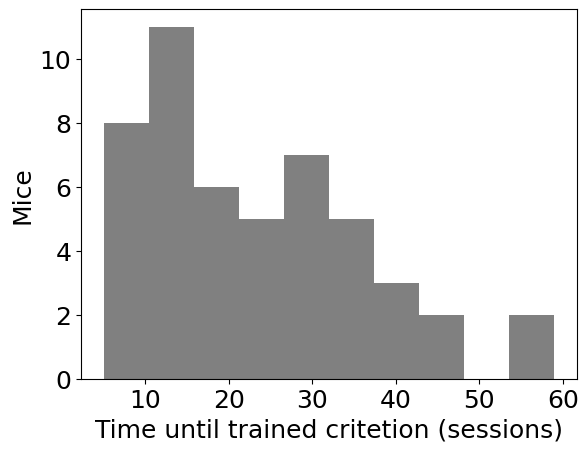

In [ ]:
# plt.figure(figsize=(9, 5))
plt.rcParams.update({'font.size': 18})

plt.hist(freq_df['training_time'], color='grey')
plt.xlabel('Time until trained critetion (sessions)')
plt.ylabel('Mice')
plt.savefig(file_path+'training_time_hist.svg', format="svg")


In [6]:
np.min(freq_df['training_time'])

5.0

In [8]:
freq_df['mouse_names'].unique()

KeyError: 'mouse_names'

                    sum_sq    df         F    PR(>F)
mouse_cluster   394.356914   1.0  2.340295  0.132769
Residual       7919.847167  47.0       NaN       NaN
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
   0.0    1.0 -11.6444 0.0281 -22.2331 -1.0557   True
   0.0    2.0   -7.325 0.2436 -18.2104  3.5604  False
   1.0    2.0   4.3194 0.5774  -6.0872 14.7261  False
-----------------------------------------------------


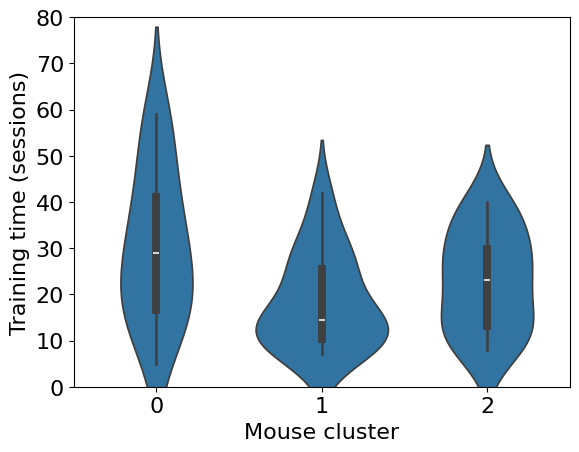

P-value for KW: 0.056
          0.0       1.0       2.0
0.0  1.000000  0.048716  0.656035
1.0  0.048716  1.000000  0.739468
2.0  0.656035  0.739468  1.000000


In [71]:


var_1 = 'training_time ~ mouse_cluster'
var = 'training_time'
# Define the model using ordinary least squares (OLS) and fit it
data = freq_df.dropna()
model = ols(var_1, data=data).fit()

# Perform the ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)  # Type 2 ANOVA DataFrame

print(anova_table)

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=data[var], groups=data['mouse_cluster'], alpha=0.05)

print(tukey)
plt.rcParams.update({'font.size': 16})
# sns.boxplot(x='mouse_cluster', y=var, data=freq_df)
# sns.scatterplot(x='mouse_cluster', y=var, data=freq_df)
sns.violinplot(x='mouse_cluster', y=var, data=data)
plt.xticks([0, 1, 2], [0, 1, 2])
# plt.yticks([0, 1, 2, 3, 4], [0, 1, 2, 3, 4])
plt.ylim([0, 80])
plt.xlabel('Mouse cluster')
plt.ylabel('Proportion correct')
# plt.ylabel('Reaction time (s)')
# plt.ylabel('Proportion ballistic movements')
# plt.ylabel('Pre-quiescence duration (s)')
plt.ylabel('Training time (sessions)')
# plt.ylabel('Reaction time (s)')
plt.savefig(file_path+'training_time.svg', format="svg")

plt.show()


group_1 = freq_df.loc[freq_df['mouse_cluster']==0, var]
group_2 = freq_df.loc[freq_df['mouse_cluster']==1, var]
group_3 = freq_df.loc[freq_df['mouse_cluster']==2, var]

stat, p_value = stats.kruskal(group_1, group_2, group_3)
print(f"P-value for KW: {p_value:.3f}")

posthoc = sp.posthoc_dunn(freq_df.dropna(), val_col=var, group_col='mouse_cluster', p_adjust='bonferroni')
print(posthoc)


In [8]:
posthoc = sp.posthoc_dunn(freq_df.dropna(), val_col='training_time', group_col='mouse_cluster', p_adjust='bonferroni')

In [9]:
posthoc

,0.0,1.0,2.0
0.0,1.000000,0.048716,0.656035
1.0,0.048716,1.000000,0.739468
2.0,0.656035,0.739468,1.000000


In [138]:
group_1 = freq_df.loc[freq_df['mouse_cluster']==0, 'training_time']
group_2 = freq_df.loc[freq_df['mouse_cluster']==1, 'training_time']
t_stat, p_value = ttest_ind(group_1, group_2)
print(f"t-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

t-statistic: 1.902
P-value: 0.066


In [3]:
a = session_perf[['mouse_name', 'session']].merge(mouse_states[['mouse_name', 'mouse_cluster']]).drop_duplicates()
a.to_pickle("./mouse_cluster_by_session.pkl")  

NameError: name 'session_perf' is not defined

In [88]:
mouse_perf = pd.DataFrame(trial_states.groupby(['mouse_name'])['correct'].mean()).reset_index()
df = mouse_states.merge(mouse_perf, on='mouse_name')


In [89]:
session_perf = pd.DataFrame(trial_states.groupby(['mouse_name', 'session'])['correct'].mean()).reset_index()
df = session_perf.merge(mouse_states, on='mouse_name')

In [90]:
learning_times = learning_times.rename(columns={"subject_nickname": "mouse_name"}).reset_index()
df = df.merge(learning_times, on='mouse_name')


In [91]:
# Pivot the DataFrame
freq_df = df.reset_index().pivot(index=['mouse_cluster', 'correct',  'training_time'], columns=['cluster'], values='relative_frequency') # 'session',
# To flatten the column MultiIndex
freq_df[freq_df.isna()] = 0
freq_df = freq_df.reset_index()

In [23]:
# Pivot the DataFrame
freq_df = df.reset_index().pivot(index=['mouse_name', 'mouse_cluster', 'correct', 'training_time'], columns=['cluster'], values='relative_frequency')
# To flatten the column MultiIndex
freq_df[freq_df.isna()] = 0
freq_df = freq_df.reset_index()

KeyError: 'training_time'

In [24]:
# Pivot the DataFrame
freq_df = df.reset_index().pivot(index=['mouse_name', 'mouse_cluster', 'correct'], columns=['cluster'], values='relative_frequency')
# To flatten the column MultiIndex
freq_df[freq_df.isna()] = 0
freq_df = freq_df.reset_index()

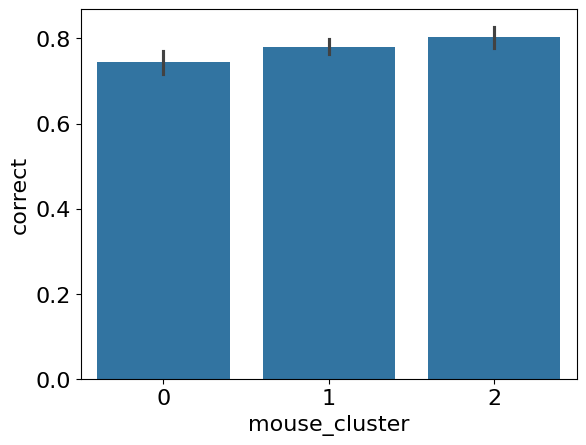

t-statistic: -2.243
P-value: 0.028
t-statistic: 2.984
P-value: 0.004


/tmp/ipykernel_8050/2145000629.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='mouse_cluster', y='training_time', palette=sns.cubehelix_palette(3,as_cmap=False), data=freq_df)


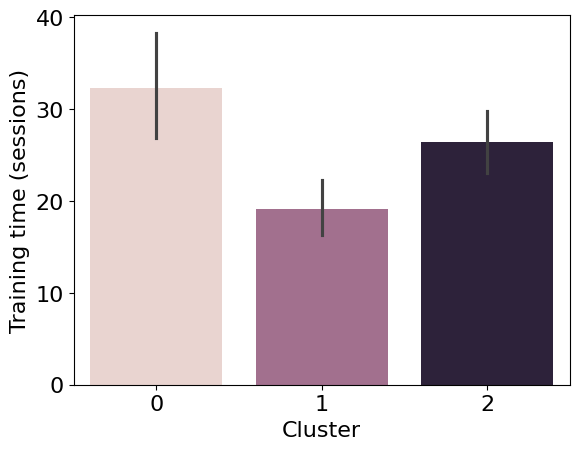

In [92]:
sns.barplot(x='mouse_cluster', y='correct', data=freq_df)
plt.show()
# Perform two-sample t-test
group_1 = freq_df.loc[freq_df['mouse_cluster']==0, 'correct']
group_2 = freq_df.loc[freq_df['mouse_cluster']==1, 'correct']
t_stat, p_value = ttest_ind(group_1, group_2)
print(f"t-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

plt.rcParams.update({'font.size': 16})

sns.barplot(x='mouse_cluster', y='training_time', palette=sns.cubehelix_palette(3,as_cmap=False), data=freq_df)

# Perform two-sample t-test

group_1 = freq_df.loc[freq_df['mouse_cluster']==2, 'training_time']
group_2 = freq_df.loc[freq_df['mouse_cluster']==1, 'training_time']
t_stat, p_value = ttest_ind(group_1, group_2)
plt.xlabel('Cluster')
plt.ylabel('Training time (sessions)')
print(f"t-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

In [27]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

var_1 = 'correct ~ mouse_cluster'
var_2 = 'correct'
# Define the model using ordinary least squares (OLS) and fit it
model = ols(var_1, data=freq_df).fit()

# Perform the ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)  # Type 2 ANOVA DataFrame

print(anova_table)

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=freq_df[var_2], groups=freq_df['mouse_cluster'], alpha=0.05)

print(tukey)

                 sum_sq    df         F    PR(>F)
mouse_cluster  0.038820   1.0  9.468824  0.003417
Residual       0.200889  49.0       NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1   0.0406 0.1639 -0.0124 0.0937  False
     0      2   0.0697 0.0103  0.0144 0.1249   True
     1      2    0.029 0.3887  -0.024 0.0821  False
---------------------------------------------------


In [28]:
group_1 = freq_df.loc[freq_df['mouse_cluster']==1, 'correct']
group_2 = freq_df.loc[freq_df['mouse_cluster']==2, 'correct']
t_stat, p_value = ttest_ind(group_1, group_2)
print(f"t-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")


t-statistic: -1.351
P-value: 0.186


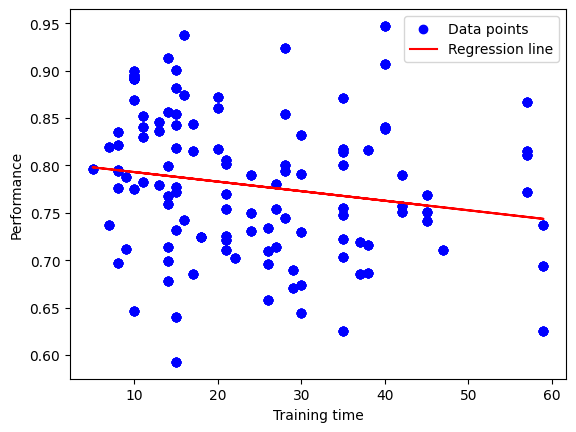

0.03407374560785448
Pearson correlation coefficient: -0.185
P-value: 0.000


In [17]:
# X values (independent variable)
X = np.array(df['training_time']).reshape(-1, 1)

# y values (dependent variable)
y = np.array(df['correct'])

# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)

# Predictions from the model
y_pred = model.predict(X)

# Plot the original data points
plt.scatter(X, y, color='blue', label='Data points')
# Plot the regression line
plt.plot(X, y_pred, color='red', label='Regression line')
# Add labels and title
plt.xlabel('Training time')
plt.ylabel('Performance')

# Show the legend
plt.legend()
# Show the plot
plt.show()

print(model.score(X, y))

# Compute Pearson correlation
correlation, p_value = pearsonr(df['training_time'], df['correct'])
print(f"Pearson correlation coefficient: {correlation:.3f}")
print(f"P-value: {p_value:.3f}")

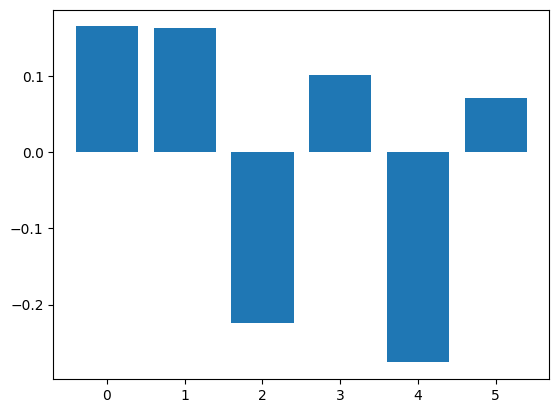

Predicted performance: [0.74150233 0.74150233 0.74150233 0.76507971 0.76507971 0.78225699
 0.76234183 0.69508694 0.79498649 0.79498649 0.67750486 0.72432845
 0.72432845 0.81296085 0.73498914 0.73498914 0.73498914 0.76934725
 0.76934725 0.76934725 0.76934725 0.76934725 0.76934725 0.76934725]


0.1493420240994714

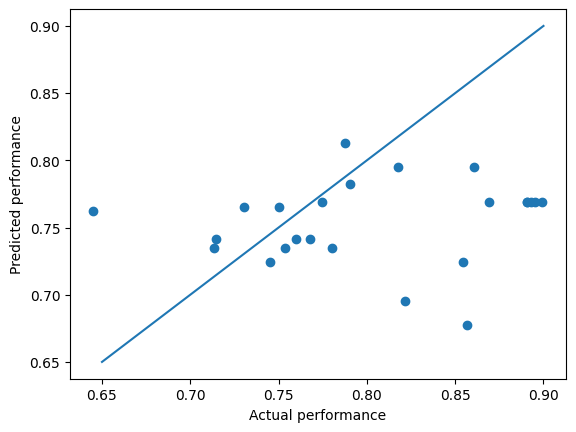

In [16]:
predicted_var = 'training_time'
predicted_var = 'correct'
cutoff = int(0.8*len(freq_df))
# X = np.array(freq_df[[0, 1, 2, 3, 4, 5, 6, 7]][:cutoff])
X = np.array(freq_df[[0, 1, 2, 3, 4, 5]][:cutoff])
# X = np.array(freq_df['mouse_cluster'][:40])
y = np.array(freq_df[predicted_var][:cutoff])

model = LinearRegression()
model.fit(X, y)
# plt.bar([0, 1, 2, 3, 4, 5, 6, 7], model.coef_)
plt.bar([0, 1, 2, 3, 4, 5], model.coef_)

plt.show()
# Predict performance for a new mouse with 50% trial type 1 and 50% trial type 4
# new_mouse = np.array(freq_df[[0, 1, 2, 3, 4, 5, 6, 7]][cutoff:])
new_mouse = np.array(freq_df[[0, 1, 2, 3, 4, 5]][cutoff:])

y_pred = model.predict(new_mouse)

print("Predicted performance:", y_pred)
y_true = np.array(freq_df[predicted_var][cutoff:])
plt.scatter(y_true, y_pred)
plt.plot([0.65, .9], [0.65, .9])
plt.xlabel('Actual performance')
plt.ylabel('Predicted performance')
model.score(X, y)
